## 消费行为分析报告

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
columns = ['user_id','order_dt','order_products','order_amount']
df = pd.read_table('CDNOW_master.txt',names = columns,sep = '\s+')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


- user_id:用户ID
- order_dt:购买日期
- order_products:购买产品数
- order_amount:购买金额

In [11]:
df.head()

,user_id,order_dt,order_products,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id           69659 non-null int64
order_dt          69659 non-null int64
order_products    69659 non-null int64
order_amount      69659 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [13]:
df.describe()

,user_id,order_dt,order_products,order_amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


- 大部分订单只消费了少量商品（平均2.4），有一定的极值干扰
- 用户的消费金额比较稳定，平均消费35元，中位数在35元，有一定的极值干扰

In [14]:
df['order_dt'] = pd.to_datetime(df.order_dt,format='%Y%m%d')
df['month'] = df.order_dt.values.astype('datetime64[M]')

In [15]:
df.head()

,user_id,order_dt,order_products,order_amount,month
0,1,1997-01-01,1,11.77,1997-01-01
1,2,1997-01-12,1,12.00,1997-01-01
2,2,1997-01-12,5,77.00,1997-01-01
3,3,1997-01-02,2,20.76,1997-01-01
4,3,1997-03-30,2,20.76,1997-03-01


## 1.进行用户消费趋势的分析（按月）
- 每月的消费总金额
- 每月的消费次数
- 每月的产品购买量
- 每月的消费人数

In [16]:
grouped_month = df.groupby('month')
order_month_amount = grouped_month.order_amount.sum()
order_month_amount.head()

month
1997-01-01    299060.17
1997-02-01    379590.03
1997-03-01    393155.27
1997-04-01    142824.49
1997-05-01    107933.30
Name: order_amount, dtype: float64

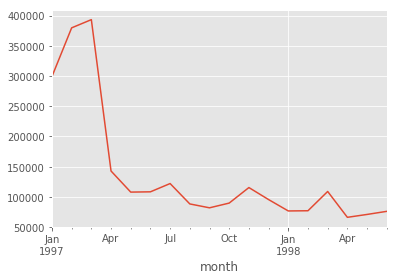

In [17]:
plt.style.use('ggplot')
order_month_amount.plot()

由上图可知，消费金额在前三个月达到最高峰，后续消费额较为稳定，有轻微下降趋势

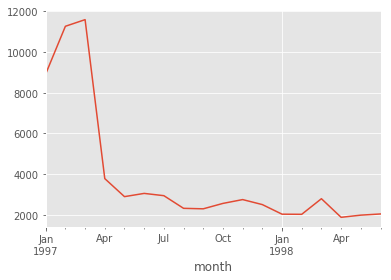

In [19]:
grouped_month.user_id.count().plot()

前三个月消费**订单数**在10000笔左右，后续月份平均2500笔

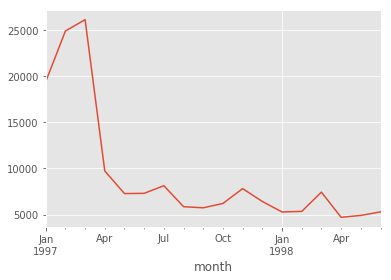

In [20]:
grouped_month.order_products.sum().plot()

每月消费的总产品数

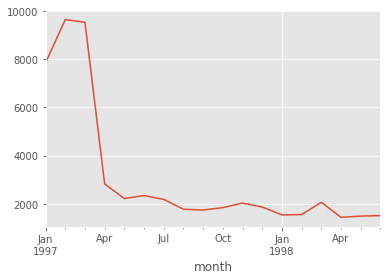

In [21]:
df.groupby('month').user_id.apply(lambda x:len(x.drop_duplicates())).plot()

每月的消费人数低于每月的消费次数，但差异不大

前三个月每月的消费人数在8000-10000之间，后续月份平均消费人数在2000人不到

In [22]:
df.pivot_table(index = 'month',
              values = ['order_products','order_amount','user_id'],
              aggfunc = {'order_products':'sum',
                        'order_amount':'sum',
                        'user_id':'count'}).head()

,order_amount,order_products,user_id
month,,,
1997-01-01,299060.17,19416,8928
1997-02-01,379590.03,24921,11272
1997-03-01,393155.27,26159,11598
1997-04-01,142824.49,9729,3781
1997-05-01,107933.30,7275,2895


## 2.用户个体消费分析
- 用户消费金额、消费次数的描述统计
- 用户消费金额和消费的散点图
- 用户消费金额的分布图
- 用户消费次数的分布图
- 用户累计消费金额占比（百分之多少的用户占了百分之多少的消费额）

In [23]:
grouped_user = df.groupby('user_id')

In [24]:
grouped_user.sum().describe()

,order_products,order_amount
count,23570.000000,23570.000000
mean,7.122656,106.080426
std,16.983531,240.925195
min,1.000000,0.000000
25%,1.000000,19.970000
50%,3.000000,43.395000
75%,7.000000,106.475000
max,1033.000000,13990.930000


- 用户平均购买了7张CD，但是中位数只有3，说明小部分用户购买了大量CD
- 用户平均消费106元，中位数为43，判断同上，有极值干扰

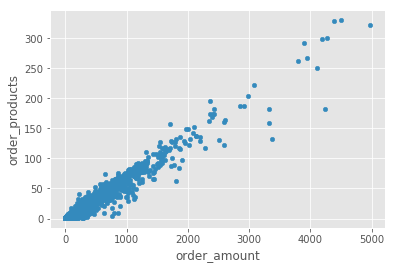

In [25]:
grouped_user.sum().query('order_amount < 6000').plot.scatter(x = 'order_amount',y = 'order_products')
#排除极值

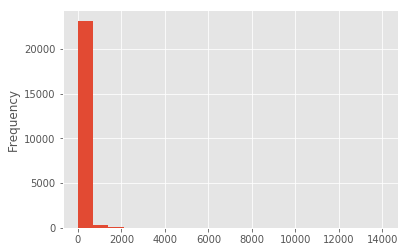

In [26]:
grouped_user.sum().order_amount.plot.hist(bins = 20)

从直方图可知，用户消费金额，绝大部分呈现集中趋势，小部分异常值干扰了判断。可以使用**过滤操作**排除异常

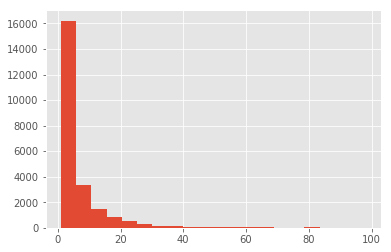

In [27]:
grouped_user.sum().query('order_products < 100').order_products.hist(bins = 20)

使用切比雪夫定理过滤掉异常值，计算95%的数据的分布情况

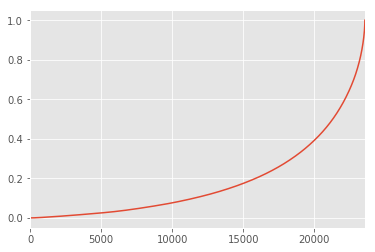

In [28]:
user_cumsum = grouped_user.sum().sort_values('order_amount').apply(lambda x:x.cumsum()/x.sum())
user_cumsum.reset_index().order_amount.plot()

按用户消费金额进行升序排列，由图可知50%的用户仅贡献了15%的消费额度，而排名前5000的用户就贡献了40%的消费额

## 3.用户消费行为

- 用户第一次消费（首购）
- 用户最后一次消费
- 新老客消费比
  - 多少用户仅消费一次？
  - 每月新客占比？
- 用户分层
  - RFM
  - 新、活跃、回流、流失
- 用户购买周期（按订单）
  - 用户消费周期描述
  - 用户消费周期分布
- 用户生命周期（按第一次&最后一次消费）
  - 用户生命周期描述
  - 用户生命周期分布

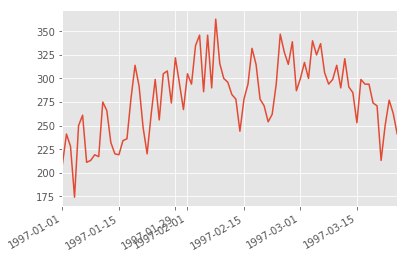

In [29]:
grouped_user.min().order_dt.value_counts().plot()

用户第一次购买分布，集中在前三个月

二月上旬有一次剧烈波动

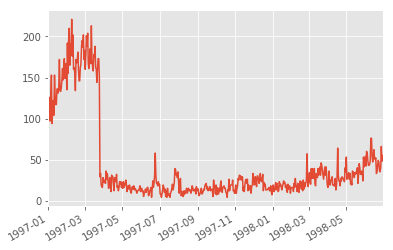

In [30]:
grouped_user.max().order_dt.value_counts().plot()

用户最后一次购买的分布比第一次购买的分布广

大部分最后一次购买集中在前三个月，说明有很多用户购买了一次后就不再进行购买

随着时间的递增，最后一次购买数也在递增，消费呈现流失上升的情况

In [31]:
user_life = grouped_user.order_dt.agg(['min','max'])
user_life.head()

,min,max
user_id,,
1,1997-01-01,1997-01-01
2,1997-01-12,1997-01-12
3,1997-01-02,1998-05-28
4,1997-01-01,1997-12-12
5,1997-01-01,1998-01-03


In [32]:
(user_life['min'] == user_life['max']).value_counts()

True     12054
False    11516
dtype: int64

有一半的用户只**消费了一次**

In [33]:
rfm = df.pivot_table(index = 'user_id',
                    values = ['order_products','order_amount','order_dt'],
                    aggfunc = {'order_dt':'max',
                              'order_amount':'sum',
                              'order_products':'sum'
                              })
rfm.head()

,order_amount,order_dt,order_products
user_id,,,
1,11.77,1997-01-01,1
2,89.00,1997-01-12,6
3,156.46,1998-05-28,16
4,100.50,1997-12-12,7
5,385.61,1998-01-03,29


In [34]:
rfm['R'] = (rfm.order_dt.max()-rfm.order_dt)/np.timedelta64(1,'D')
rfm.rename(columns = {'order_products':'F','order_amount':'M'},inplace = True)

In [41]:
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
    }
    result = d[label]
    return result

rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1)

In [38]:
rfm.head()

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1997-01-01,1,545.0,一般发展客户
2,89.00,1997-01-12,6,534.0,一般发展客户
3,156.46,1998-05-28,16,33.0,重要保持客户
4,100.50,1997-12-12,7,200.0,一般挽留客户
5,385.61,1998-01-03,29,178.0,重要保持客户


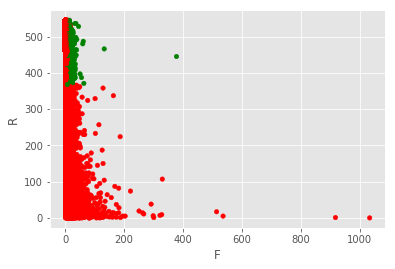

In [51]:
rfm.loc[rfm.label == '重要价值客户','color'] = 'g'
rfm.loc[~(rfm.label == '重要价值客户'),'color'] = 'r'
rfm.plot.scatter('F','R',c = rfm.color)

In [52]:
rfm.groupby('label').sum()

,M,F,R
label,,,
一般价值客户,7181.28,650,36295.0
一般保持客户,19937.45,1712,29448.0
一般发展客户,438291.81,29346,6951815.0
一般挽留客户,196971.23,13977,591108.0
重要价值客户,167080.83,11121,358363.0
重要保持客户,1592039.62,107789,517267.0
重要发展客户,33028.40,1263,114482.0
重要挽留客户,45785.01,2023,56636.0


从RFM分层可知，大部分用户为重要保持客户，但是这是由于极值的影响，所以RFM的划分标准应该以业务为准

In [146]:
pivoted_counts = df.pivot_table(index = 'user_id',
                               columns = 'month',
                               values = 'order_dt',
                               aggfunc = 'count').fillna(0)
pivoted_counts.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [147]:
df_purchase = pivoted_counts.applymap(lambda x:1 if x>0 else 0)
df_purchase.tail()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
23566,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23567,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23568,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23569,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23570,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [148]:
def active_status(data):
    status = []
    for i in range(18):
        
        #若本月没有消费
        if data[i] == 0:
            if len(status)>0:
                if status[i-1] == 'unreg':
                    status.append('unreg')
                else:
                    status.append('unactive')
            else:
                status.append('unreg')
            
        #若本月消费
        else:
            if len(status) == 0:
                status.append('new')
            else:
                if status[i-1] == 'unactive':
                    status.append('return')
                elif status[i-1] == 'unreg':
                    status.append('new')
                else:
                    status.append('active')
    return status

若本月没有消费

 - 若之前是未注册，则依旧为未注册
 - 若之前有消费，则为流失/不活跃
 - 其他情况为未注册
 
若本月有消费
 
 - 若是第一次消费，则为新用户
 - 如果之前有过消费，则上个月为不活跃，则为回流
 - 如果上个月为未注册，则为新用户
 - 除此之外为活跃

In [166]:
purchase_stats = df_purchase.apply(active_status,axis = 1)
purchase_stats = purchase_stats.to_frame()
purchase_stats = pd.DataFrame(purchase_stats[0].tolist(), columns=df_purchase.columns)
purchase_stats.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
0,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
1,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
2,new,unactive,return,active,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,return,unactive
3,new,unactive,unactive,unactive,unactive,unactive,unactive,return,unactive,unactive,unactive,return,unactive,unactive,unactive,unactive,unactive,unactive
4,new,active,unactive,return,active,active,active,unactive,return,unactive,unactive,return,active,unactive,unactive,unactive,unactive,unactive


In [167]:
purchase_stats.tail()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
23565,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23566,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23567,unreg,unreg,new,active,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23568,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
23569,unreg,unreg,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive


In [172]:
purchase_stats_ct = purchase_stats.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x))
purchase_stats_ct

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
active,NaN,1157.0,1681,1773.0,852.0,747.0,746.0,604.0,528.0,532.0,624.0,632.0,512.0,472.0,571.0,518.0,459.0,446.0
new,7846.0,8476.0,7248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
return,NaN,NaN,595,1049.0,1362.0,1592.0,1434.0,1168.0,1211.0,1307.0,1404.0,1232.0,1025.0,1079.0,1489.0,919.0,1029.0,1060.0
unactive,NaN,6689.0,14046,20748.0,21356.0,21231.0,21390.0,21798.0,21831.0,21731.0,21542.0,21706.0,22033.0,22019.0,21510.0,22133.0,22082.0,22064.0


In [169]:
purchase_stats_ct.fillna(0).T.head()

,active,new,return,unactive
month,,,,
1997-01-01,0.0,7846.0,0.0,0.0
1997-02-01,1157.0,8476.0,0.0,6689.0
1997-03-01,1681.0,7248.0,595.0,14046.0
1997-04-01,1773.0,0.0,1049.0,20748.0
1997-05-01,852.0,0.0,1362.0,21356.0


In [171]:
purchase_stats_ct.fillna(0).T.apply(lambda x:x/x.sum(),axis = 1)

,active,new,return,unactive
month,,,,
1997-01-01,0.000000,1.000000,0.000000,0.000000
1997-02-01,0.070886,0.519299,0.000000,0.409815
1997-03-01,0.071319,0.307510,0.025244,0.595927
1997-04-01,0.075223,0.000000,0.044506,0.880272
1997-05-01,0.036148,0.000000,0.057785,0.906067
1997-06-01,0.031693,0.000000,0.067543,0.900764
1997-07-01,0.031650,0.000000,0.060840,0.907510
1997-08-01,0.025626,0.000000,0.049555,0.924820
1997-09-01,0.022401,0.000000,0.051379,0.926220


由上表可知，每月的用户消费状态变化

 - 活跃用户，持续消费的用户，对应的是消费运营的质量
 - 回流用户，之前不消费本月才消费，对应的是唤回
 - 不活跃用户，对应的是流失

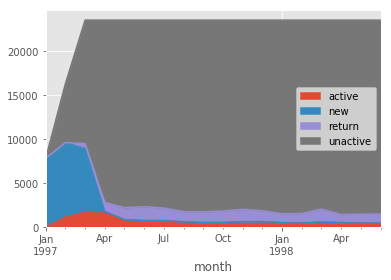

In [170]:
purchase_stats_ct.fillna(0).T.plot.area()

In [174]:
order_diff = grouped_user.apply(lambda x:x.order_dt - x.order_dt.shift())
order_diff.head(10)

user_id   
1        0        NaT
2        1        NaT
         2     0 days
3        3        NaT
         4    87 days
         5     3 days
         6   227 days
         7    10 days
         8   184 days
4        9        NaT
Name: order_dt, dtype: timedelta64[ns]

In [175]:
order_diff.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: order_dt, dtype: object

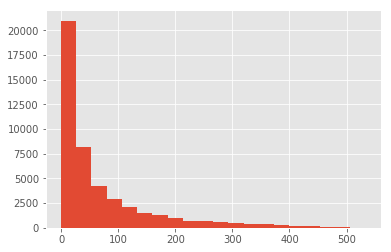

In [176]:
(order_diff/np.timedelta64(1,'D')).hist(bins=20)

- 订单周期呈指数分布
- 用户的平均购买周期是68天
- 绝大部分用户的购买周期都低于100天

In [177]:
(user_life['max'] - user_life['min']).describe()

count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
dtype: object

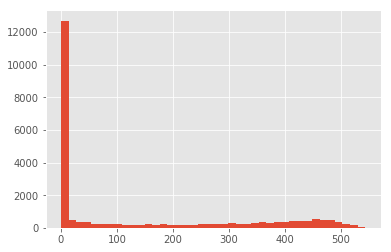

In [178]:
((user_life['max'] - user_life['min'])/np.timedelta64(1,'D')).hist(bins = 40)

- 用户的生命周期受只购买一次的用户影响比较厉害（可以排除）
- 用户平均消费134天，**中位数仅为0天**

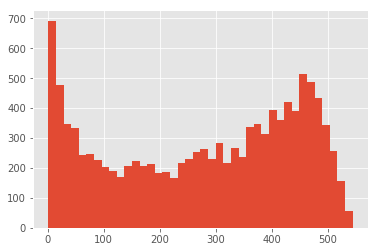

In [186]:
u_1 = (user_life['max'] - user_life['min']).reset_index()[0]/np.timedelta64(1,'D')
u_1[u_1>0].hist(bins = 40)

## 4.复购率和回购率分析

 - 复购率：自然月内购买多次的用户占比
 - 回购率：曾经购买过的用户在某一时期内再次购买的占比

In [188]:
pivoted_counts.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [189]:
purchase_r = pivoted_counts.applymap(lambda x:1 if x>1 else np.NaN if x==0 else 0)
purchase_r.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


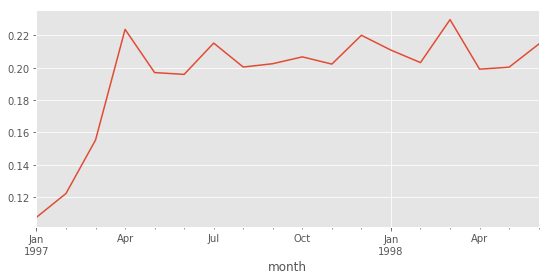

In [191]:
(purchase_r.sum()/purchase_r.count()).plot(figsize=(9,4))

复购率稳定在20%左右，前三个月因为有大量新用户涌入，而这批用户只购买了一次，所以导致复购率降低

In [192]:
df_purchase.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
user_id,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,1,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,0,0


In [193]:
def purchase_back(data):
    status = []
    for i in range (17):
        if data[i] == 1:
            if data[i+1] == 1:
                status.append(1)
            if data[i+1] == 0:
                status.append(0)
        else:
            status.append(np.NaN)
    status.append(np.NaN)
    return status

In [196]:
purchase_b = df_purchase.apply(purchase_back,axis = 1)
purchase_b = purchase_b.to_frame()
purchase_b = pd.DataFrame(purchase_b[0].tolist(), columns=df_purchase.columns)
purchase_b.head()

month,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,1998-04-01 00:00:00,1998-05-01 00:00:00,1998-06-01 00:00:00
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.0,NaN,1.0,1.0,1.0,0.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN


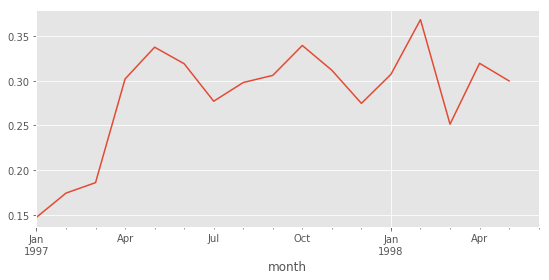

In [198]:
(purchase_b.sum()/purchase_b.count()).plot(figsize=(9,4))